In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import scanpy as sc
import anndata as ad


from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict

In [7]:
grnboost = pd.read_table("/Users/yuanzan/Documents/github/seqyuan/tomato_graft_omics/data/grn/grn_notbook/gene_energy_sugar_grnboost2_addtype.csv", sep="\t")
adata = ad.read_h5ad("/Users/yuanzan/Documents/github/seqyuan/tomato_graft_omics/data/grn/grn_notbook/CC_DD_Exp_energy_sugar.h5ad")

In [8]:
grnboost_sub = grnboost.query('importance>=35')

grnboost_sub['targetN'] = grnboost_sub.groupby(["TF"]).sum()['cc'][grnboost_sub['TF']].to_list()
grnboost_sub = grnboost_sub.query('targetN>=6')
grnboost_sub['targetN'] = grnboost_sub.groupby(["TF"]).sum()['cc'][grnboost_sub['TF']].to_list()

grnboost_sub = grnboost_sub.sort_values(by=['targetN'])
#grnboost_sub['dupTarget'] = grnboost_sub.duplicated('target')


<ipython-input-8-96841fc8ce7a>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grnboost_sub['targetN'] = grnboost_sub.groupby(["TF"]).sum()['cc'][grnboost_sub['TF']].to_list()
<ipython-input-8-96841fc8ce7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grnboost_sub['targetN'] = grnboost_sub.groupby(["TF"]).sum()['cc'][grnboost_sub['TF']].to_list()
<ipython-input-8-96841fc8ce7a>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or 

In [9]:
grnboost_sub.groupby(["TF"]).sum()['cc']

<ipython-input-9-2367075c054e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grnboost_sub.groupby(["TF"]).sum()['cc']


TF
2-Phospho-D-glycerate          10
ADP                           103
AMP                            13
ATP                           151
Acetyl-CoA                    151
Adenine                         9
Ara                            14
Beta-Leucine                   21
Citric-acid                   122
D-Erythrose-4-phosphate        16
D-Glucose-1-phosphate          19
D-Glucose-6-phosphate          10
D-Ribulose-5-phosphate          8
Dihydroxyacetone-phosphate     14
Fru                            25
Gal                            50
Glycerol-3-phosphate           11
L-Alanine                      50
L-Arginine                     19
L-Asparagine                   44
L-Citrulline                    9
L-Glutamate                    32
L-Lactate                       8
L-Threonine                    12
L-Tyrosine                    127
Lysine                        105
Phosphoenolpyruvic-acid        62
Phosphorylethanolamine        450
Pyruvic-acid                   11
Rha        

In [18]:
grnboost_sub.groupby(["TF", 'target_type']).sum().loc['Suc',:]

<ipython-input-18-f7e8530505ac>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grnboost_sub.groupby(["TF", 'target_type']).sum().loc['Suc',:]


,importance,cc,targetN
target_type,,,
TF,2452.356619,55,43450
TR,471.433371,11,8690
gene,31330.979607,724,571960


In [21]:
grnboost_sub.to_csv('../../data/grn/suc_grnboost_importance35_targetN6.csv', sep="\t", index=False)

In [24]:
grnboost_sub.query('TF=="Suc" and (target_type=="TF" or target_type=="TR")').to_csv('../../data/grn/suc_importance35_targetN6.csv', sep="\t", index=False)


In [25]:
grnboost_sub.query('TF=="Suc" and (target_type=="TF" or target_type=="TR")')

,TF,target,importance,cc,TF_type,target_type,targetN
2501,Suc,Solyc10g076460.2,35.962453,1,sugar,TF,790
412,Suc,Solyc05g052610.3,49.789240,1,sugar,TF,790
2480,Suc,Solyc04g078770.4,36.027338,1,sugar,TF,790
564,Suc,Solyc04g080740.1,47.305903,1,sugar,TF,790
474,Suc,Solyc04g009440.3,48.620021,1,sugar,TF,790
...,...,...,...,...,...,...,...
884,Suc,Solyc06g005680.4,44.026730,1,sugar,TF,790
983,Suc,Solyc02g092460.3,43.194171,1,sugar,TR,790
982,Suc,Solyc09g090130.3,43.203793,1,sugar,TF,790
975,Suc,Solyc01g109970.3,43.284457,1,sugar,TR,790


In [10]:
nodes = list(set(pd.concat([grnboost_sub["TF"], grnboost_sub["target"]], axis=0)))
nodes = adata.var.loc[nodes,:]
nodes.head(2)

,type
Solyc06g082070.3,gene
Solyc06g076350.3,TF


In [11]:
def subG(df):
    G = nx.Graph()
    G.clear()
    nodes = list(set(pd.concat([df["TF"], df["target"]], axis=0)))
    subG = nx.Graph()
    
    for i in nodes:
        G.add_node(i)
    for i,row in df.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    return G


In [152]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())

In [170]:
import matplotlib.colors as mcolors
keys = list(mcolors.CSS4_COLORS)

In [174]:
#keys

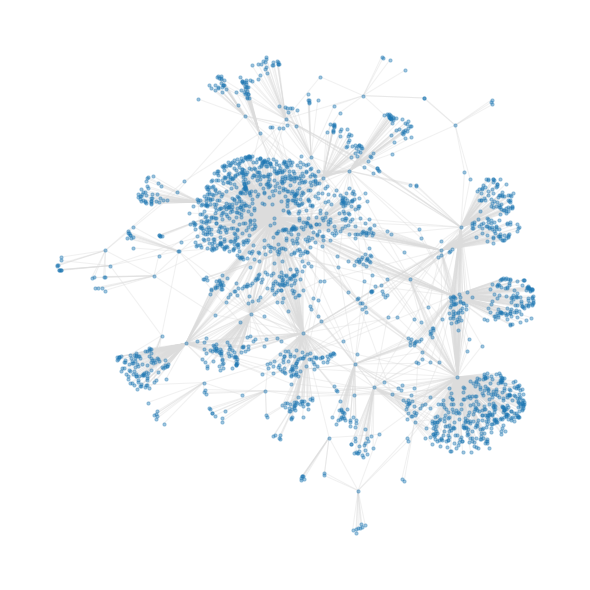

In [272]:
G = nx.Graph()
G.clear()

nodes = list(set(pd.concat([grnboost_sub["TF"], grnboost_sub["target"]], axis=0)))
nodes_df = adata.var.loc[nodes,:]
nodes_df['range'] = range(nodes_df.shape[0])

for i in nodes_df.index:
    G.add_node(i)

for i, row in grnboost_sub.iterrows():
    G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    
    
for i in grnboost_sub["TF"].unique():
    subdf = grnboost_sub[grnboost_sub["TF"]==i]
    sG = subG(subdf)
    U = nx.disjoint_union(U, sG)
    #break
    
#### draw graph ####
plt.figure(1, figsize=(8, 8))
# layout graphs with positions using graphviz neato

H = G.subgraph(next(nx.connected_components(G)))
# Makes life easier to have consecutively labeled integer nodes
H = nx.convert_node_labels_to_integers(H)
# Create parititions with hierarchical clustering
partitions = create_hc(H)
# Build blockmodel graph
BM = nx.quotient_graph(H, partitions, relabel=True)

# Draw original graph
pos = nx.spring_layout(H, iterations=20, seed=83)  # Seed for reproducibility






nx.draw(H, pos, with_labels=False, node_size=10, edge_color="gainsboro", alpha=0.4)



/tmp/ipykernel_1036807/2239920485.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  target_count = pd.DataFrame(grn_DF.groupby(["TF"]).sum()['cc'])
/tmp/ipykernel_1036807/2239920485.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_count = target_count.append(notIntarget_count)
/tmp/ipykernel_1036807/2239920485.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  target_count = pd.DataFrame(grn_DF.groupby(["TF"]).sum()['cc'])
/tmp/ipykernel_1036807/2239920485.py:24: FutureWarning: The frame.append method is d

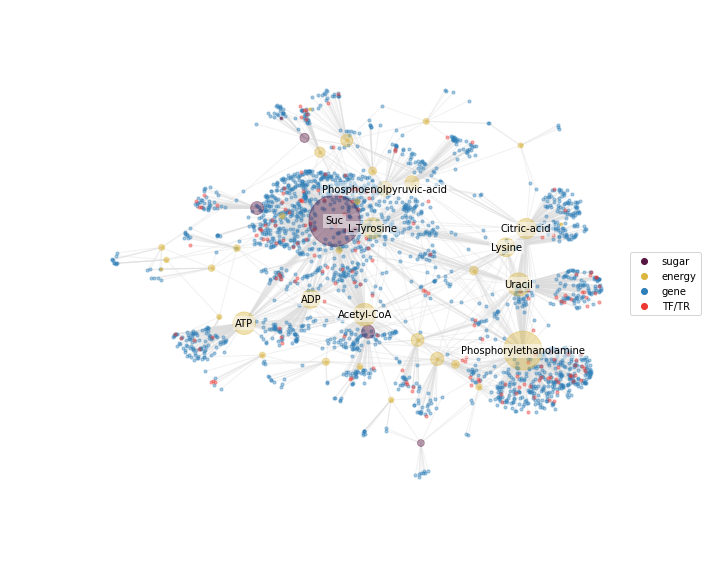

In [325]:

pos = nx.nx_agraph.graphviz_layout(U, prog="neato")



plt.figure(1, figsize=(10, 8))

def plot_target_node(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['range'].to_list()
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, node_color=nodecolor, alpha=alpha)
    
nodes1 = plot_target_node(H, pos, nodes_df[nodes_df.index.isin(grn_DF['TF'])==False], nodetype="gene", nodecolor="#2E7EB7", node_size=10)
nodes2 = plot_target_node(H, pos, nodes_df[nodes_df.index.isin(grn_DF['TF'])==False], nodetype="sugar", nodecolor="#581642", node_size=10)
nodes3 = plot_target_node(H, pos, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=10)
nodes4 = plot_target_node(H, pos, nodes_df, nodetype="TF", nodecolor="#ED3833", node_size=10)
nodes5 = plot_target_node(H, pos, nodes_df, nodetype="TR", nodecolor="#ED3833", node_size=10)
    
    
def plot_TF_node(GG, poss, grn_DF, nodeDF, nodetype="sugar", nodecolor="red", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['range'].to_list()
    
    target_count = pd.DataFrame(grn_DF.groupby(["TF"]).sum()['cc'])
    aa = nodeDF.index.isin(target_count.index)==False
    notIntarget_count = nodeDF.index[aa].to_list()
    
    notIntarget_count = pd.DataFrame({'cc':[1]*len(notIntarget_count)}, index=notIntarget_count)
    target_count = target_count.append(notIntarget_count)
    
    #target_count.loc[notIntarget_count, 'cc'] = [1]
    #print(target_count)
    
    node_size = node_size * target_count.loc[nodeDF.index, 'cc']/6
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, 
                                     node_color=nodecolor, 
                                     #label=nodeDF.index.to_list(), 
                                     alpha=alpha)
    
nodes6 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="sugar", nodecolor="#581642", node_size=20)
nodes7 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=20)

top7TFs = grnboost_sub[['TF', 'targetN']].sort_values(['targetN'], ascending=False).drop_duplicates().head(10)['TF'].to_list()
top7TFs = nodes_df.loc[top7TFs,:]

bbox={'facecolor': 'w', #填充色
      'edgecolor': 'None',#外框色
      'alpha': 0.5, #框透明度
      'pad': 2,#本文与框周围距离
     }

nx.draw_networkx_labels(H, pos, labels={row['range']:i for i,row in top7TFs.iterrows()}, 
                        font_size=10, 
                        font_family="sans-serif", 
                        font_color='k',
                        bbox=bbox
                        )




edge_colors = grnboost_sub['importance'].to_list()
cmap = plt.cm.plasma

edges = nx.draw_networkx_edges(H, pos, edge_color="gainsboro", alpha=0.4)

ax = plt.gca()
ax.scatter(None,None, label='sugar', color='#581642')
ax.scatter(None,None, label='energy', color='#DBB53E')
ax.scatter(None,None, label='gene', color='#2E7EB7')
ax.scatter(None,None, label='TF/TR', color='#ED3833')
ax.legend(loc=5)
ax.margins(0.15)
plt.axis("off")
plt.tight_layout()


#ax.set_axis_off()
#plt.show()
plt.savefig("tomato_geneExp_energy_sugar_Comodule_network.pdf")


# style 3

In [465]:
grnboost_sub_bar = grnboost.query('importance>=35')
grnboost_sub_bar.loc[grnboost_sub_bar[grnboost_sub_bar['target_type']=='TF'].index, "target_type"] = 'TF/TR'
grnboost_sub_bar.loc[grnboost_sub_bar[grnboost_sub_bar['target_type']=='TR'].index, "target_type"] = 'TF/TR'
grnboost_sub_bar = pd.DataFrame(grnboost_sub_bar.groupby(["TF", 'TF_type', 'target_type']).sum()['cc'])
grnboost_sub_bar = grnboost_sub_bar.reset_index()
grnboost_sub_bar = grnboost_sub_bar.sort_values(by=['cc', 'target_type'], ascending=False)
grnboost_sub_bar.columns = ['Sugar_Energy', 'Sugar_Energy_type', 'Gene/metabolite class', 'Cooperative dynamic\nGene/metabolite number']


/tmp/ipykernel_1036807/3719034143.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grnboost_sub_bar = pd.DataFrame(grnboost_sub_bar.groupby(["TF", 'TF_type', 'target_type']).sum()['cc'])


# states

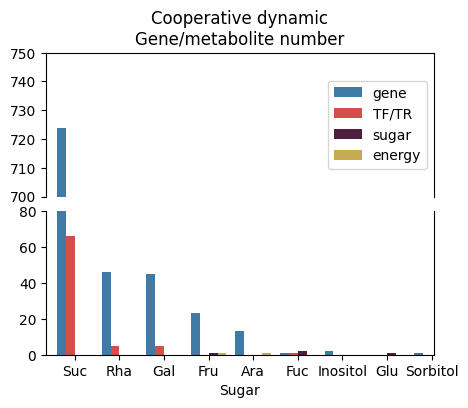

In [467]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, dpi=100, figsize=(5,4))
fig.subplots_adjust(hspace=0.1)


palette=['#2E7EB7', '#ED3833', '#581642', '#DBB53E']
sns.barplot(ax=ax1, data=grnboost_sub_bar.query('Sugar_Energy_type=="sugar"'), color=palette, palette=palette,
            x="Sugar_Energy", y="Cooperative dynamic\nGene/metabolite number", hue="Gene/metabolite class")
sns.barplot(ax=ax2, data=grnboost_sub_bar.query('Sugar_Energy_type=="sugar"'), color=palette, palette=palette,
            x="Sugar_Energy", y="Cooperative dynamic\nGene/metabolite number", hue="Gene/metabolite class")

ax2.set_ylim(0, 80)  #  子图1设置y轴范围，只显示部分图
ax1.set_ylim(700, 750)  # 子图2设置y轴范围，只显示部分图

ax1.legend(loc=5)
ax2.margins(0.03)
ax1.margins(0.03)
ax1.set_xticks([])
ax1.set_xlabel('')
ax2.set_xlabel('Sugar')
ax1.set_ylabel('')
ax2.set_ylabel('')

ax2.get_legend().remove()

ax1.spines['bottom'].set_visible(False)#关闭子图1中底部脊
ax2.spines['top'].set_visible(False)##关闭子图2中顶部脊


#ax = plt.add_subplot(facecolor=None)

#ax.set_axis_off()1.set_title
#ax1.set_ylabel('Cooperative dynamic\nGene/metabolite number', loc="bottom", halign='center')
#fig.align_labels() 
ax1.set_title('Cooperative dynamic\nGene/metabolite number')
#ax.set_xticks([])
#ax.set_yticks([])

fig.savefig('sugar__Cooperative_dynamic_Gene_metabolite_number.pdf')

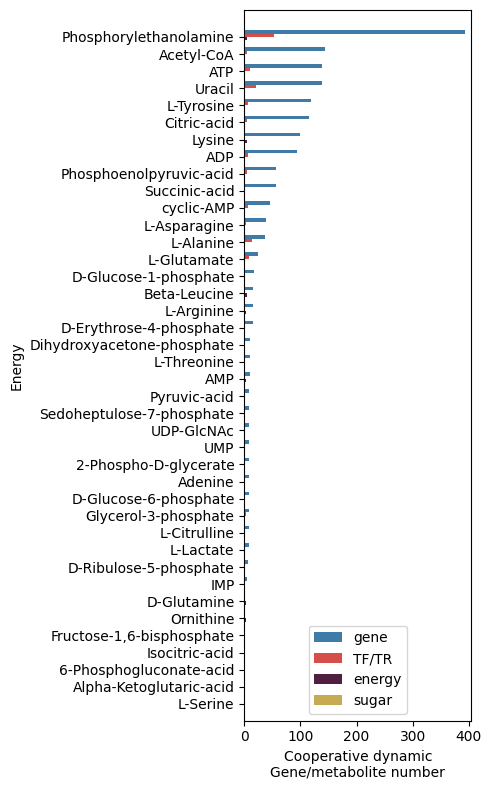

In [472]:
fig, ax = plt.subplots(1, 1, sharey=False, dpi=100, figsize=(5,8))
#fig.subplots_adjust(hspace=0.1)

ax = sns.barplot(ax=ax, data=grnboost_sub_bar.query('Sugar_Energy_type=="energy"'), color=palette, palette=palette, 
                 y="Sugar_Energy", x="Cooperative dynamic\nGene/metabolite number", 
                 hue="Gene/metabolite class")

ax.legend(loc=8)
ax.margins(0.03)
ax.set_ylabel('Energy')
plt.tight_layout()
fig.savefig('energy__Cooperative_dynamic_Gene_metabolite_number.pdf')

In [469]:
grnboost_sub_bar.to_csv("sugar_energy_coDynamic_grnboost_module.csv", index=False)